In [1]:
import os
import numpy as np

# anns_folder = '/dfs/scratch0/paroma/coco/annotations/'
anns_folder = os.environ['SNORKELHOME'] + '/tutorials/babble/bike/data/'
train_path = anns_folder + 'train_anns.npy'
val_path = anns_folder + 'val_anns.npy'

train_anns = np.load(train_path).tolist()
val_anns = np.load(val_path).tolist()

In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [5]:
from snorkel.models import candidate_subclass
Biker = candidate_subclass('Biker', ['person', 'bike'])

In [6]:
from snorkel.parser import ImageCorpusExtractor, CocoPreprocessor

corpus_extractor = ImageCorpusExtractor(candidate_class=Biker)

coco_preprocessor = CocoPreprocessor(train_path, source=0)
%time corpus_extractor.apply(coco_preprocessor)

coco_preprocessor = CocoPreprocessor(val_path, source=1)
%time corpus_extractor.apply(coco_preprocessor, clear=False)

for split in [0, 1]:
    num_candidates = session.query(Biker).filter(Biker.split == split).count()
    print("Split {} candidates: {}".format(split, num_candidates))

Clearing existing...
Running UDF...
CPU times: user 8.9 s, sys: 348 ms, total: 9.25 s
Wall time: 9.29 s
Running UDF...
CPU times: user 2.11 s, sys: 128 ms, total: 2.24 s
Wall time: 2.26 s
Split 0 candidates: 2406
Split 1 candidates: 1037


In [7]:
candidates = session.query(Biker).all()
labels_by_candidate = np.load(anns_folder + 'labels_by_candidate.npy').tolist()

In [8]:
from snorkel.models import StableLabel
from snorkel.db_helpers import reload_annotator_labels

candidate_class = Biker
annotator_name = 'gold'

for candidate_hash, label in labels_by_candidate.items():
    set_name, image_idx, bbox1_idx, bbox2_idx = candidate_hash.split(':')
    source = {'train': 0, 'val': 1}[set_name]
    stable_id_1 = "{}:{}::bbox:{}".format(source, image_idx, bbox1_idx)
    stable_id_2 = "{}:{}::bbox:{}".format(source, image_idx, bbox2_idx)
    context_stable_ids = "~~".join([stable_id_1, stable_id_2])
    query = session.query(StableLabel).filter(StableLabel.context_stable_ids == context_stable_ids)
    query = query.filter(StableLabel.annotator_name == annotator_name)
    label = 1 if label else -1
    if query.count() == 0:
        session.add(StableLabel(
            context_stable_ids=context_stable_ids,
            annotator_name=annotator_name,
            value=label))

session.commit()
reload_annotator_labels(session, candidate_class, annotator_name, split=1, filter_label_split=False)

AnnotatorLabels created: 906


In [9]:
stable_labels = session.query(StableLabel).filter(StableLabel.annotator_name == annotator_name).all()
candidates = session.query(Biker).filter(Biker.split == 1).all()

print(candidates[0])

Biker(Bbox(val:0:3:person:(248.88, 305.52, 438.54, 455.78)), Bbox(val:0:1:bike:(303.56, 358.9, 455.17, 533.18)))


In [10]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<1037x1 sparse matrix of type '<type 'numpy.int64'>'
	with 906 stored elements in Compressed Sparse Row format>

### Making CSV for Payal

In [46]:
train_mscoco = np.load(anns_folder+'train_mscoco.npy')
val_mscoco = np.load(anns_folder+'val_mscoco.npy')

In [87]:
candidates = session.query(Biker).filter(Biker.split == 1).all()
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev = np.array(L_gold_dev.todense())

In [23]:
num_candidates = len(candidates)

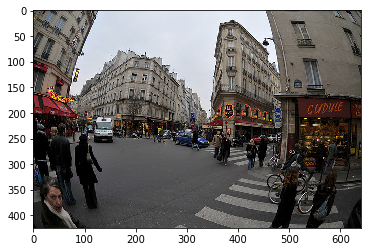

In [70]:
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

c = candidates[0]
I = io.imread('http://mscoco.org/images/'+str(val_mscoco[int(c.bike.stable_id.split(":")[1])]))
plt.imshow(I)

In [140]:
coco_ids =  np.zeros(len(val_anns))
labels = np.zeros(len(val_anns))

for idx in range(num_candidates):
    cand = candidates[idx]
    image_id = int(cand.bike.stable_id.split(":")[1])
    mscoco_id = val_mscoco[image_id]
    import pdb
    if mscoco_id == 0:
        pdb.set_trace()
    coco_ids[image_id] = int(mscoco_id)

    label = L_gold_dev[idx]
    if label == 1: #only record true
        labels[image_id] = 1

In [136]:
import csv
with open('validation_images.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    
    for idx in range(len(coco_ids)):
        if coco_ids[idx] == 0:
            continue
        else:
            csvwriter.writerow(['http://mscoco.org/images/'+str(int(coco_ids[idx])),
                                labels[idx]])